In [43]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import anatools.analysis as ana
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from hhdm_analysis.mlp.methods import MLP
from hhdm_analysis.mlp.callbacks import EvaluateOnDataset
from hhdm_analysis.utils import position

# Disable GPUs
tf.config.set_visible_devices([], 'GPU')

ana.start()
plt.style.use("default")

# Setup config

In [73]:
period = '18'
year_style = 2018
dataset_year = "2018"
basedir = '/home/gamoreir/SanDisk/physics/hhdmAnalysis_deepJet_Regions/datasets'
dataset_name = basedir.split('/')[-2]

# Data folder
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)

# Setup output folders
models_path = f"./models/{dataset_name}/{dataset_year}"
Path(models_path).mkdir(parents=True, exist_ok=True)

# Read metadata

In [45]:
with open("../metadata.json", "r") as f:
    metadata = json.load(f)

# Read data

In [46]:
model_name = "MLP_multi_signal"
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]

X_train = pd.read_csv(f"{data_path}/{model_name}-train-data.csv")
X_test = pd.read_csv(f"{data_path}/{model_name}-test-data.csv")
W_train = X_train.pop("modelWeight").values
W_test = X_test.pop("modelWeight").values
Y_train = X_train.pop("Label").values
Y_test = X_test.pop("Label").values
evtWeight_train = X_train.pop("evtWeight").values
evtWeight_test = X_test.pop("evtWeight").values

In [5]:
X_train.head()

,LeadingLep_pt,LepLep_deltaM,LepLep_deltaR,LepLep_pt,MET_LepLep_Mt,MET_LepLep_deltaPhi,MET_pt,MT2LL,Nbjets,TrailingLep_pt
0,-1.130300,1.604904,0.349870,-1.181807,-0.884643,0.492711,-0.607189,-0.784605,-0.756234,-0.956230
1,-1.036404,-1.470962,1.092621,-1.207214,-1.005160,0.622338,-0.780956,-0.965908,-0.756234,-0.896125
2,-0.859722,-1.309577,-0.145494,-1.005630,-0.892622,-0.922285,-0.781883,-0.801464,-0.756234,-0.797736
3,-1.033726,-0.685424,0.464417,-1.139371,-0.728276,-0.096213,-0.344909,-0.643619,0.625712,-0.922024
4,-1.023518,-1.286104,0.283472,-1.149471,-0.464118,-0.041318,0.431084,-0.317362,0.625712,-0.696899


In [6]:
W_train

array([ 5.17864467e-07, -1.17983767e-05,  1.86961597e-06, ...,
        2.33257130e-08, -2.71026276e-08,  2.02497107e-09])

In [7]:
Y_train

array([0, 0, 0, ..., 0, 0, 0])

# Complex model

In [8]:
# Evaluate callback
# eod = EvaluateOnDataset(f"{models_path}/{model_name}-eval-log.txt", train_data=(X_train.values, Y_train, W_train), test_data=(X_test.values, Y_test, W_test), validation_step=10)

# EarlyStopping callback
es = EarlyStopping(monitor="val_loss", mode="min", patience=300, verbose=1)

# ModelCheckpoint callback
mc = ModelCheckpoint(f"{models_path}/{model_name}-checkpoint.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Store model history with CSVLogger
csv_logger = CSVLogger(f"{models_path}/{model_name}-training-log.csv", separator=',', append=False)

# Model
model = MLP(
    neurons_per_layer=[20, 20],
    activation_functions=["elu", "elu", "sigmoid"],
    optimizer=Adam(lr=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    num_classes=1
)
model.build(features_size=len(features))

# Train
history = model.model.fit(
    X_train.values,
    Y_train,
    sample_weight=W_train,
    batch_size=1000,
    epochs=2000,
    verbose=2,
    validation_data=(
        X_test.values,
        Y_test,
        W_test
    ),
    callbacks=[es, mc, csv_logger], #, eod],
)

# We do not need to manually save the model after training because ModelCheckpoint callback
# will save the best model each time a condition is check during training
# i.e. the last saved model by checkpoint is the best model

2023-02-15 10:47:58.900082: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-15 10:47:58.900205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1261] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-15 10:47:58.900225: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1267]      
2023-02-15 10:50:56.092733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-02-15 10:50:56.093571: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599995000 Hz


Epoch 1/2000
681/681 - 183s - loss: 2.8874e-07 - accuracy: 0.7113 - val_loss: 2.3431e-07 - val_accuracy: 0.8049

Epoch 00001: val_loss improved from inf to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
Epoch 2/2000
681/681 - 3s - loss: 2.3187e-07 - accuracy: 0.7992 - val_loss: 2.3192e-07 - val_accuracy: 0.7800

Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
Epoch 3/2000
681/681 - 3s - loss: 2.2805e-07 - accuracy: 0.8065 - val_loss: 2.2648e-07 - val_accuracy: 0.7958

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
Epoch 4/2000
681/681 - 3s - loss: 2.2278e-07 - accuracy: 0.8150 - val_loss: 2.2813e-07 - val_accuracy: 0.7798

Epoch 00004: val_loss did not improve from 0.00000
Epoch 5/2000
681/681 - 3s - loss: 2.1977e-07 - accuracy: 

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Plot model loss history

best_epoch 683
train_loss on best_epoch 6.827329457337329e-08
test_loss on best_epoch 6.973906607754543e-08


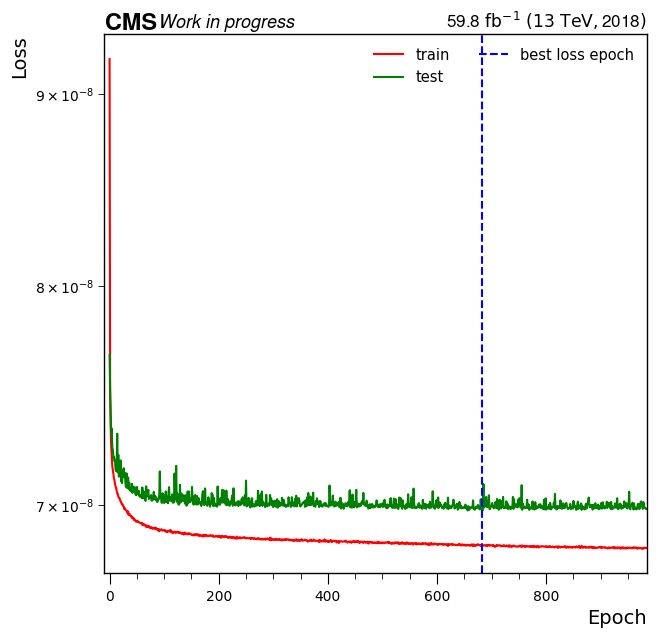

In [74]:
# Variables
try:
    train_loss = np.array(history.history["loss"])
    test_loss = np.array(history.history["val_loss"])
    best_epoch = np.argmin(test_loss)
except:
    # In case we try to manipulate the plot without re-training the model we can load the training log
    df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
    train_loss = np.array(df["loss"])
    test_loss = np.array(df["val_loss"])
    best_epoch = np.argmin(test_loss)
    
print("best_epoch", best_epoch)
print("train_loss on best_epoch", train_loss[best_epoch])
print("test_loss on best_epoch", test_loss[best_epoch])

# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(train_loss, label="train", color="red")
ax1.plot(test_loss, label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.savefig(f"{figures_path}/MLP_score_keras-loss_history-{model_name}.png", dpi=200, facecolor='white')
plt.show()
plt.close()

# Plot model accuracy history

best_epoch 683
train_acc on best_epoch 0.8249290585517883
test_acc on best_epoch 0.8233213424682617


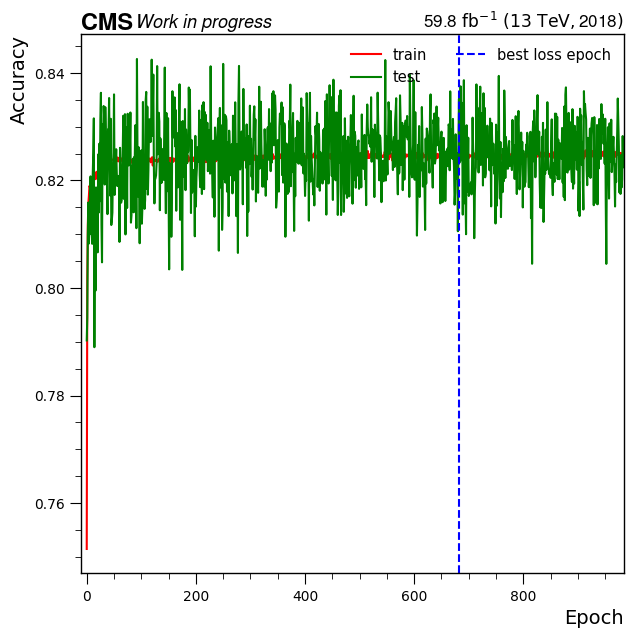

In [75]:
try:
    train_acc = np.array(history.history["accuracy"])
    test_acc = np.array(history.history["val_accuracy"])
except:
    # In case we try to manipulate the plot without re-training the model we can load the training log
    df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
    train_acc = np.array(df["accuracy"])
    test_acc = np.array(df["val_accuracy"])

print("best_epoch", best_epoch)
print("train_acc on best_epoch", train_acc[best_epoch])
print("test_acc on best_epoch", test_acc[best_epoch])
    
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(train_acc, label="train", color="red")
ax1.plot(test_acc, label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Accuracy", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.savefig(f"{figures_path}/MLP_score_keras-acc_history-{model_name}.png", dpi=200, facecolor='white')
plt.show()
plt.close()

# Test metrics plot using EOD callback

In [76]:
# # Variables
# train_loss = np.array(history.history["eval_train_loss"])
# test_loss = np.array(history.history["eval_test_loss"])
# best_epoch = np.argmin(test_loss)

# # Plot config
# fig = plt.figure(figsize=(7,7))
# grid = [1,1] # number of rows, number of cols
# gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# # Plot code
# ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
# ax1.plot(train_loss, label="train", color="red")
# ax1.plot(test_loss, label="test", color="green")
# ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
# ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
# ana.style(
#     ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
#     ylog=False, legend_ncol=2
# )
# plt.savefig(f"{figures_path}/MLP_score_keras-eval_loss_history-{model_name}.png", dpi=200, facecolor='white')
# plt.show()
# plt.close()


# # Variables
# train_acc = np.array(history.history["eval_train_acc"])
# test_acc = np.array(history.history["eval_test_acc"])

# # Plot config
# fig = plt.figure(figsize=(7,7))
# grid = [1,1] # number of rows, number of cols
# gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# # Plot code
# ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
# ax1.plot(train_acc, label="train", color="red")
# ax1.plot(test_acc, label="test", color="green")
# ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
# ana.labels(ax1, ylabel="Accuracy", xlabel="Epoch")
# ana.style(
#     ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
#     ylog=False, legend_ncol=2
# )
# plt.savefig(f"{figures_path}/MLP_score_keras-eval_acc_history-{model_name}.png", dpi=200, facecolor='white')
# plt.show()
# plt.close()

# Testing rolling mean

best_epoch 683
train_loss on best_epoch 6.827329457337329e-08
test_loss on best_epoch 6.973906607754543e-08


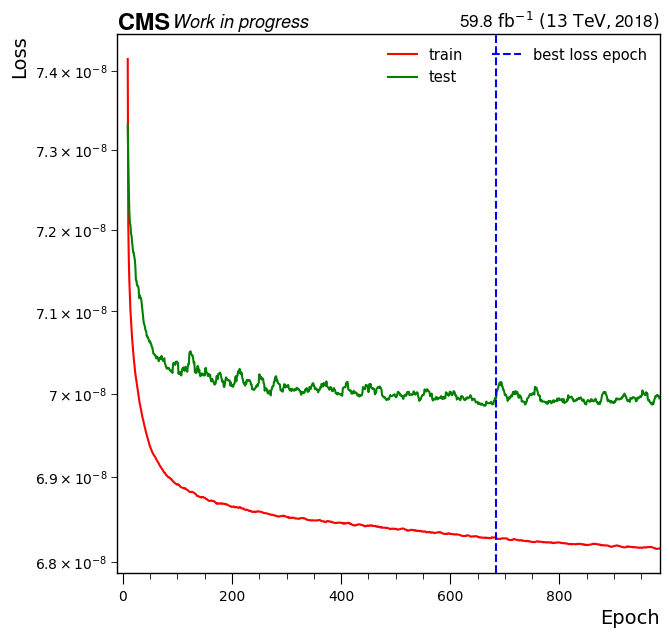

In [77]:
# Variables
df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
train_loss = np.array(df["loss"])
test_loss = np.array(df["val_loss"])
best_epoch = np.argmin(test_loss)
    
print("best_epoch", best_epoch)
print("train_loss on best_epoch", train_loss[best_epoch])
print("test_loss on best_epoch", test_loss[best_epoch])

## Rolling
df["rolling_loss_10"] = df.loss.rolling(10).mean()
df["rolling_val_loss_10"] = df.val_loss.rolling(10).mean()

# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(df["rolling_loss_10"], label="train", color="red")
ax1.plot(df["rolling_val_loss_10"], label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.show()
plt.close()

best_epoch 683
train_acc on best_epoch 0.8249290585517883
test_acc on best_epoch 0.8233213424682617


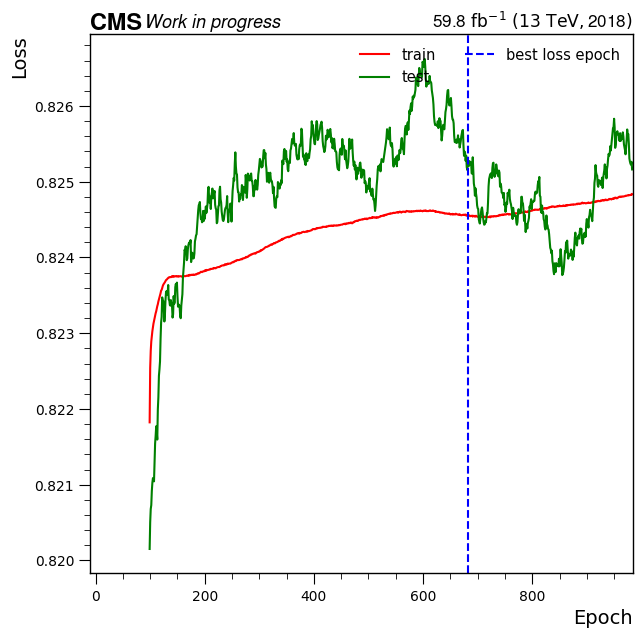

In [78]:
# Variables
df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
train_acc = np.array(df["accuracy"])
test_acc = np.array(df["val_accuracy"])
    
print("best_epoch", best_epoch)
print("train_acc on best_epoch", train_acc[best_epoch])
print("test_acc on best_epoch", test_acc[best_epoch])

## Rolling
df["rolling_accuracy_100"] = df.accuracy.rolling(100).mean()
df["rolling_val_accuracy_100"] = df.val_accuracy.rolling(100).mean()

# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(df["rolling_accuracy_100"], label="train", color="red")
ax1.plot(df["rolling_val_accuracy_100"], label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.show()
plt.close()